# Strange Flows

Investigating some ideas about strange attractors, chaos theory, and normalizing flows.

In [1]:
import jax.numpy as np
from jax import random, grad
from jax.experimental import optimizers, stax
from numba import jit
import itertools

import flows

from sklearn import datasets
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Simulated Data

We'll use the following simulated data throughout the notebook...

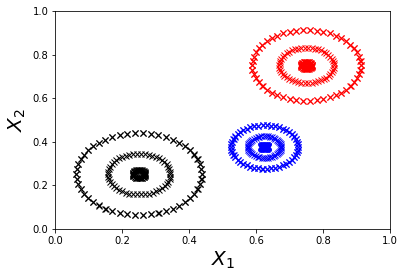

In [2]:
noisy_circles1 = datasets.make_circles(100, factor=.1, noise=.001)
noisy_circles2 = datasets.make_circles(100, factor=.5, noise=.001)

# scale and shift the data
nc1 = .125 * (1.5 * np.vstack([noisy_circles1[0], noisy_circles2[0]]) - np.array([2, 2])) + .5
nc2 = .125 * np.vstack([1.3 * np.vstack([noisy_circles1[0], noisy_circles2[0]]) + np.array([2, 2])]) + .5
nc3 = .125 * np.vstack([.8 * np.vstack([noisy_circles1[0], noisy_circles2[0]]) + np.array([1, -1])]) + .5
data = np.vstack([nc1, nc2, nc3])

plt.plot(data[:200,0], data[:200,1], "kx")
plt.plot(data[200:400,0], data[200:400,1], "rx")
plt.plot(data[400:,0], data[400:,1], "bx")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("$X_{1}$", fontsize=20)
plt.ylabel("$X_{2}$", fontsize=20)
plt.show()

### Density Detructors

We begin by examining a class of normalizing flows termed [density destructors](http://proceedings.mlr.press/v80/inouye18a.html) (DDs).  DDs are defined by the following generative model: $$\mathbf{u} \sim \text{Uniform}(0, 1), \ \ \ \ \ \mathbf{x} = T(\mathbf{u}; \boldsymbol{\theta}).$$  When DDs are fit via maximum likelihood estimation, the optimization objective is: $$D_{KL}[p^{*}(\mathbf{x}) \ || \ p(\mathbf{x}; \boldsymbol{\theta})] = -\mathbb{E}_{p^{*}}\left[ \log p_{u}(T^{-1}(\mathbf{x}; \boldsymbol{\theta})) + \log \det J_{T^{-1}}(\mathbf{x}; \boldsymbol{\theta})  \right] + \mathcal{C} \approx -\frac{1}{N}\sum_{n} \log p_{u}(T^{-1}(\mathbf{x}_{n}; \boldsymbol{\theta})) + \log \det J_{T^{-1}}(\mathbf{x}_{n}; \boldsymbol{\theta}) + \mathcal{C}.$$  And since $\log \text{Uniform}(0, 1) = 0$, the density term drops out, yielding the maximization objective: $$\mathcal{J}(\boldsymbol{\theta}) =  \frac{1}{N}\sum_{n} \log \det J_{T^{-1}}(\mathbf{x}_{n}; \boldsymbol{\theta}).$$  From this equation, we see why these models are called *destructors*: optimization's only goal is to maximize the expansion of the inverse map $T^{-1}$, spreading out (i.e. desconstructing) the data as much as possible.

First we define a flow with 20 coupling layers, each paired with an inverible linear layer.

In [3]:
rng = random.PRNGKey(42)

def shift_transform(rng, cutoff, effect_dim):
    init_fun, apply_fun = stax.serial(stax.Dense(128), stax.Relu, stax.Dense(effect_dim))
    _, params = init_fun(rng, (effect_dim,))
    return params, apply_fun

def scale_transform(rng, cutoff, effect_dim):
    init_fun, apply_fun = stax.serial(stax.Dense(128), stax.Relu, stax.Dense(effect_dim))
    _, params = init_fun(rng, (effect_dim,))
    return params, apply_fun

init_fun = flows.Serial(
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.BatchNorm(momentum=0.9),
    flows.AffineCouplingSplit(scale=scale_transform, translate=shift_transform),
    flows.InvertibleLinear(),
    flows.Sigmoid(),
)
params, direct_fun, inverse_fun = init_fun(rng, input_dim=2)

Define the optimization function:

In [4]:
def loss(params, inputs):
    return -direct_fun(params, inputs)[1].mean()

loss_grad = grad(loss)

#@jit
def step(i, opt_state, inputs):
    params = get_params(opt_state)
    gradient = loss_grad(params, inputs)
    return opt_update(i, gradient, opt_state)

Fit the flow...

In [35]:
num_epochs = 100
learning_rate = .0003

opt_init, opt_update, get_params = optimizers.adam(step_size=learning_rate)
opt_state = opt_init(params)

itercount = itertools.count()
for epoch in range(num_epochs):
    opt_state = step(next(itercount), opt_state, data)

optimized_params = get_params(opt_state)

View the transformed data and final log-likelihood...

Final Log-Likelihood: 0.959


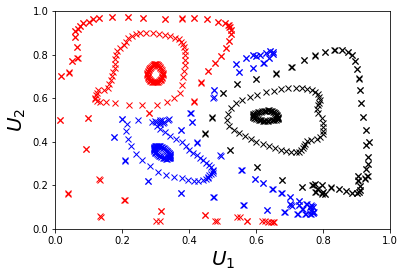

In [36]:
u_data, log_det_jacobian_direct = direct_fun(optimized_params, data)

print("Final Log-Likelihood: %.3f" %(log_det_jacobian_direct.mean()))

plt.plot(u_data[:200,0], u_data[:200,1], "kx")
plt.plot(u_data[200:400,0], u_data[200:400,1], "rx")
plt.plot(u_data[400:,0], u_data[400:,1], "bx")

plt.xlabel("$U_{1}$", fontsize=20)
plt.ylabel("$U_{2}$", fontsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

Is this data really uniformly distributed?  Let's perform a KS-test...

In [37]:
from scipy import stats

result1 = stats.kstest(rvs=u_data[:,0], cdf='uniform', args=(0,1), N=u_data.shape[0])
result2 = stats.kstest(rvs=u_data[:,1], cdf='uniform', args=(0,1), N=u_data.shape[0])

print("KS-Test for Dimension #1.  Test statistic: %.4f, p-Value: %.4f" %(result1[0], result1[1]))
print("KS-Test for Dimension #2.  Test statistic: %.4f, p-Value: %.4f" %(result2[0], result2[1]))

KS-Test for Dimension #1.  Test statistic: 0.1264, p-Value: 0.0000
KS-Test for Dimension #2.  Test statistic: 0.0711, p-Value: 0.0044


Lastly, let's look at samples from the flow...

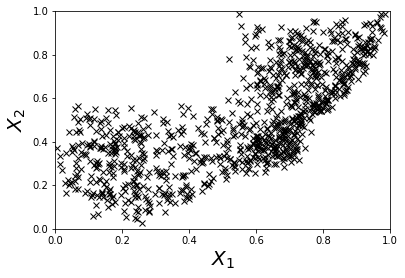

In [38]:
x_samples, _ = inverse_fun(optimized_params, random.uniform(rng, minval=0, maxval=1, shape=(1000, 2)))

plt.plot(x_samples[:,0], x_samples[:,1], "kx")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("$X_{1}$", fontsize=20)
plt.ylabel("$X_{2}$", fontsize=20)
plt.show()

### Flows from Chaotic Maps

Above we defined a density destructor using the usual parameterization.  Below we'll consider a different construction using chaos theory.  In particular, we'll consider the **Baker's map**: $$ T^{-1}(x_{1}, x_{2}) = \left( 2x_{1}, \  \frac{1}{2}x_{2} \right) \ \text{ if } 0 \le x_{1} < \frac{1}{2}, \ \ \left( 2x_{1} - 1, \  \frac{1}{2}(x_{2} + 1) \right) \ \text{ if } \frac{1}{2} \le x_{1} < 1. $$  Its inverse is then: $$ T(u_{1}, u_{2}) = \left( \frac{1}{2}u_{1}, \  2 u_{2} \right) \ \text{ if } 0 \le u_{2} < \frac{1}{2}, \ \ \left( \frac{1}{2}(u_{1} + 1), \   2u_{2} - 1 \right) \ \text{ if } \frac{1}{2} \le u_{2} < 1. $$

We implement the map below...

In [39]:
c1 = np.array([[2., .5]])
c2 = np.array([[-1., 1./2]])
c3 = np.array([[.5, 2.]])
c4 = np.array([[1./2, -1]])

def bakers_map(x):
    i = (x[:,0] >= .5).astype('int32')[np.newaxis].T
    u_temp = c1 * x
    return u_temp + np.hstack([i, i]) * c2

def inv_bakers_map(u):
    i = (u[:,1] >= .5).astype('int32')[np.newaxis].T
    x_temp = c3 * u
    return x_temp + np.hstack([i, i]) * c4
    
def T_bakers(u, n_steps=10):
    output = inv_bakers_map(u)
    for idx in range(n_steps-1):
        output = inv_bakers_map(output)
    return output

def T_inv_bakers(x, n_steps=10):
    output = bakers_map(x)
    for idx in range(n_steps-1):
        output = bakers_map(output)
    return output

Now let's iterate the map...

Final Log-Likelihood: 0.000


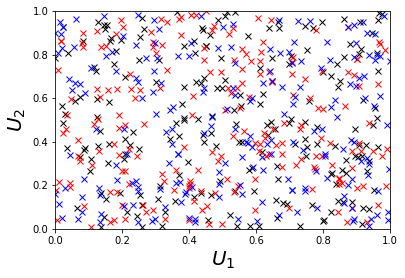

In [43]:
n_iterations = 15
baker_u = T_inv_bakers(data, n_iterations)

print("Final Log-Likelihood: %.3f" %(0.))

plt.plot(baker_u[:200,0], baker_u[:200,1], "kx")
plt.plot(baker_u[200:400,0], baker_u[200:400,1], "rx")
plt.plot(baker_u[400:,0], baker_u[400:,1], "bx")

plt.xlabel("$U_{1}$", fontsize=20)
plt.ylabel("$U_{2}$", fontsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

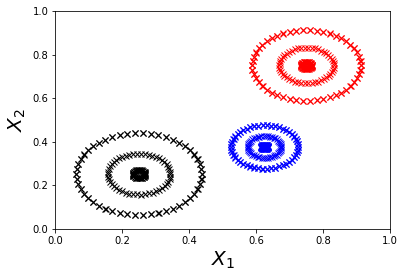

In [44]:
baker_x = T_bakers(baker_u, n_iterations)

plt.plot(baker_x[:200,0], baker_x[:200,1], "kx")
plt.plot(baker_x[200:400,0], baker_x[200:400,1], "rx")
plt.plot(baker_x[400:,0], baker_x[400:,1], "bx")

plt.xlabel("$X_{1}$", fontsize=20)
plt.ylabel("$X_{2}$", fontsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [45]:
result1 = stats.kstest(rvs=baker_u[:,0], cdf='uniform', args=(0,1), N=u_data.shape[0])
result2 = stats.kstest(rvs=baker_u[:,1], cdf='uniform', args=(0,1), N=u_data.shape[0])

print("KS-Test for Dimension #1.  Test statistic: %.4f, p-Value: %.4f" %(result1[0], result1[1]))
print("KS-Test for Dimension #2.  Test statistic: %.4f, p-Value: %.4f" %(result2[0], result2[1]))

KS-Test for Dimension #1.  Test statistic: 0.0271, p-Value: 0.7689
KS-Test for Dimension #2.  Test statistic: 0.0500, p-Value: 0.0959


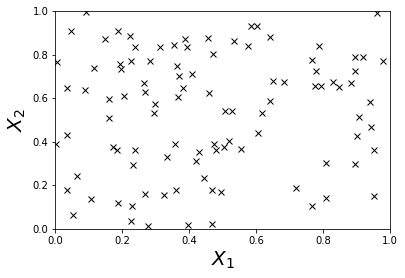

In [48]:
baker_samples = T_bakers(random.uniform(rng, minval=0, maxval=1, shape=(100, 2)), n_iterations)

plt.plot(baker_samples[:,0], baker_samples[:,1], "kx")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("$X_{1}$", fontsize=20)
plt.ylabel("$X_{2}$", fontsize=20)
plt.show()

### Examining Data w/ Lower Intrinsic Dimension

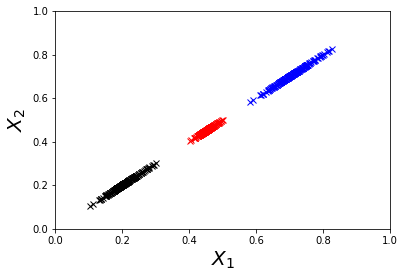

In [62]:
data_1d = np.hstack([random.normal(rng, shape=(200,)) * .04 + .2, random.normal(rng, shape=(200,)) * .02 + .45, random.normal(rng, shape=(200,)) * .05 + .7])
data_1d = np.hstack([data_1d[np.newaxis].T, data_1d[np.newaxis].T])

plt.plot(data_1d[:200,0], data_1d[:200,1], "kx")
plt.plot(data_1d[200:400,0], data_1d[200:400,1], "rx")
plt.plot(data_1d[400:,0], data_1d[400:,1], "bx")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("$X_{1}$", fontsize=20)
plt.ylabel("$X_{2}$", fontsize=20)
plt.show()

In [86]:
num_epochs = 50
learning_rate = .0003

opt_init, opt_update, get_params = optimizers.adam(step_size=learning_rate)
opt_state = opt_init(params)

itercount = itertools.count()
for epoch in range(num_epochs):
    opt_state = step(next(itercount), opt_state, data_1d)

optimized_params_1d = get_params(opt_state)

Final Log-Likelihood: 4.468


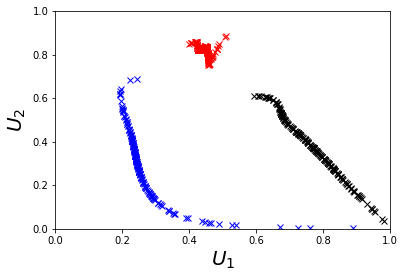

In [87]:
u_data_1d, log_det_jacobian_direct_1d = direct_fun(optimized_params_1d, data_1d)

print("Final Log-Likelihood: %.3f" %(log_det_jacobian_direct_1d.mean()))

plt.plot(u_data_1d[:200,0], u_data_1d[:200,1], "kx")
plt.plot(u_data_1d[200:400,0], u_data_1d[200:400,1], "rx")
plt.plot(u_data_1d[400:,0], u_data_1d[400:,1], "bx")

plt.xlabel("$U_{1}$", fontsize=20)
plt.ylabel("$U_{2}$", fontsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [90]:
from scipy import stats

result1 = stats.kstest(rvs=u_data_1d[:,0], cdf='uniform', args=(0,1), N=u_data.shape[0])
result2 = stats.kstest(rvs=u_data_1d[:,1], cdf='uniform', args=(0,1), N=u_data.shape[0])

print("KS-Test for Dimension #1.  Test statistic: %.4f, p-Value: %.4f" %(result1[0], result1[1]))
print("KS-Test for Dimension #2.  Test statistic: %.4f, p-Value: %.4f" %(result2[0], result2[1]))

KS-Test for Dimension #1.  Test statistic: 0.1933, p-Value: 0.0000
KS-Test for Dimension #2.  Test statistic: 0.1386, p-Value: 0.0000


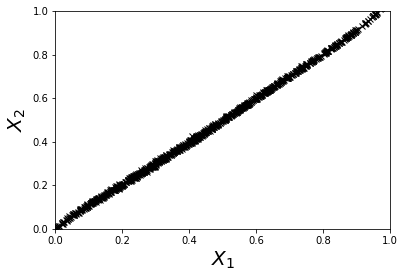

In [89]:
x_samples, _ = inverse_fun(optimized_params_1d, random.uniform(rng, minval=0, maxval=1, shape=(1000, 2)))

plt.plot(x_samples[:,0], x_samples[:,1], "kx")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("$X_{1}$", fontsize=20)
plt.ylabel("$X_{2}$", fontsize=20)
plt.show()

Final Log-Likelihood: 0.000


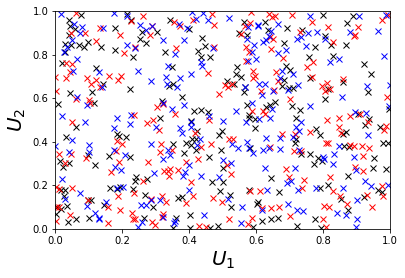

In [84]:
n_iterations = 15
baker_u_1d = T_inv_bakers(data_1d, n_iterations)

print("Final Log-Likelihood: %.3f" %(0.))

plt.plot(baker_u_1d[:200,0], baker_u_1d[:200,1], "kx")
plt.plot(baker_u_1d[200:400,0], baker_u_1d[200:400,1], "rx")
plt.plot(baker_u_1d[400:,0], baker_u_1d[400:,1], "bx")

plt.xlabel("$U_{1}$", fontsize=20)
plt.ylabel("$U_{2}$", fontsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [85]:
result1 = stats.kstest(rvs=baker_u_1d[:,0], cdf='uniform', args=(0,1), N=u_data.shape[0])
result2 = stats.kstest(rvs=baker_u_1d[:,1], cdf='uniform', args=(0,1), N=u_data.shape[0])

print("KS-Test for Dimension #1.  Test statistic: %.4f, p-Value: %.4f" %(result1[0], result1[1]))
print("KS-Test for Dimension #2.  Test statistic: %.4f, p-Value: %.4f" %(result2[0], result2[1]))

KS-Test for Dimension #1.  Test statistic: 0.0417, p-Value: 0.2409
KS-Test for Dimension #2.  Test statistic: 0.0317, p-Value: 0.5867


### Thoughts

Are multi-scale architectures implicitly learning the right dimensionality?  Or at least, instead of just being computationally convenient, it provides beneficial contraction of spurious dimensions?

Can we: (1) use a base density that forces the latent space to be axis-aligned.  (2) perform a statistical test on each dimension, with the dimensions being the closest to the base density being the ones that we can discard because the encode the least amount of structure?